### 한글 폰트 설정하기

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

[sudo] password for npswml: 
[sudo] password for npswml: 


In [1]:
# 런타임 재시작 후 아래 코드를 실행합니다.

import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

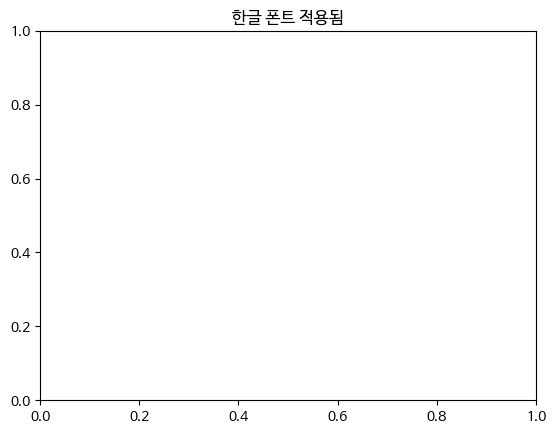

In [2]:
plt.title('한글 폰트 적용됨')
plt.show()

위 한글 폰트 적용됨 문구가 잘 나오면 정상 동작

# 데이터 불러오기

In [ ]:
!gdown 1WddbLtcEA3IBnjTaoaohUVpcOOUALeU5
!unzip helmet.zip

In [4]:
!ls

annotations  helmet.zip  image_process_practice.ipynb  images


In [1]:
import os

PATH = '.'
IMG_DIR = PATH + "/images"
XML_DIR = PATH + "/annotations"

xml_files = [os.path.join(XML_DIR, x) for x in os.listdir(XML_DIR) if x.endswith(".xml")]

In [2]:
xml_files[0]

'./annotations/hard_hat_workers2950.xml'

In [3]:
!cat ./annotations/hard_hat_workers2330.xml


<annotation>
    <folder>images</folder>
    <filename>hard_hat_workers2330.png</filename>
    <size>
        <width>416</width>
        <height>415</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>helmet</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>119</xmin>
            <ymin>192</ymin>
            <xmax>155</xmax>
            <ymax>241</ymax>
        </bndbox>
    </object>
    <object>
        <name>helmet</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>215</xmin>
            <ymin>162</ymin>
            <xmax>254</xmax>
            <ymax>207</ymax>
        </bndbox>
    </object>
</annotation>

In [4]:
import xml.etree.ElementTree as ET

#xml 파일에서 이미지 위치를 가져오기
def extract_info_from_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    labels = []
    filename = root.find('filename').text
    for boxes in root.iter('object'):
        label = boxes.find('name').text
        if label == "head" or label == "person":
          return filename, 0

    return filename, 1

In [10]:
import cv2
import numpy as np

# 이미지 특징 추출하기
img_data = []
label_data = []

for xml_file in xml_files:
    # XML 파일 파싱하기
    filename, label = extract_info_from_xml(xml_file)

    # 이미지 파일 읽기
    img_file = os.path.join(IMG_DIR, filename)
    img = cv2.imread(img_file)
    label_data.append(label)
    resized_img = cv2.resize(img, (224, 224))
    img_data.append(resized_img)

img_data = np.array(img_data)
label_data = np.array(label_data)

In [11]:
len(img_data), len(label_data)

(5000, 5000)

In [12]:
from collections import Counter

label_counter = Counter(label_data)
label_counter

Counter({1: 3940, 0: 1060})

/home/npswml/.conda/envs/tf_311/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50504 (\N{HANGUL SYLLABLE AN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/npswml/.conda/envs/tf_311/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/npswml/.conda/envs/tf_311/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/npswml/.conda/envs/tf_311/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54744 (\N{HANGUL SYLLABLE HEOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


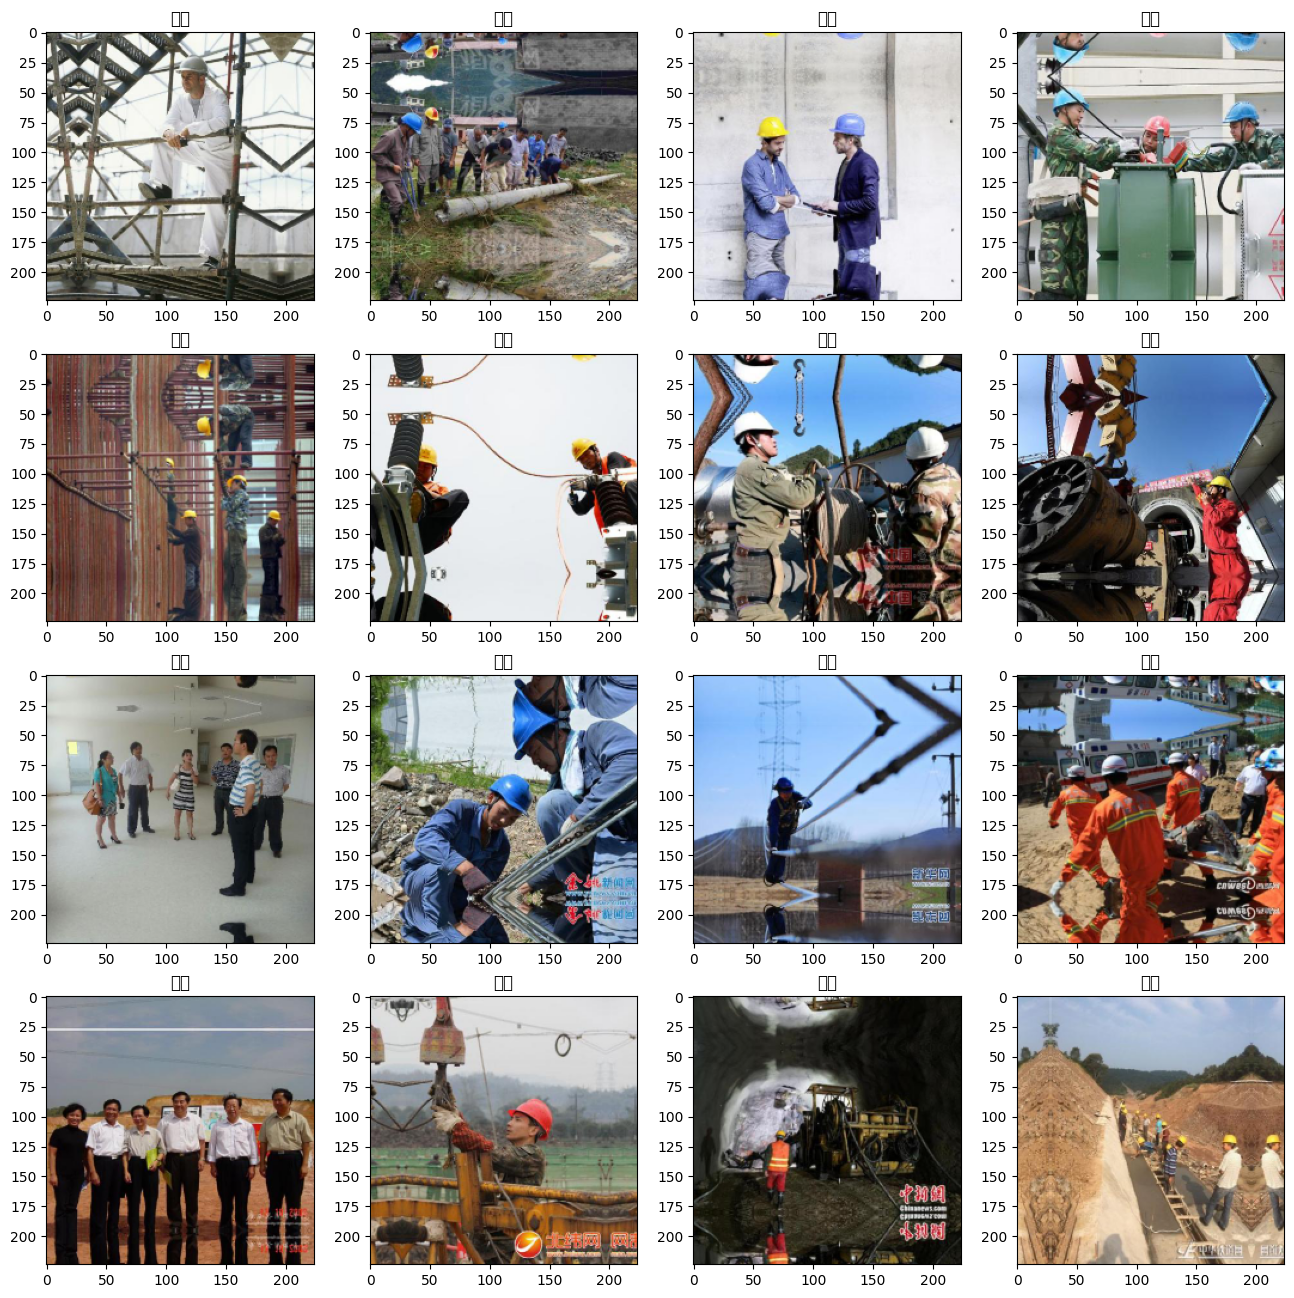

In [14]:
import matplotlib.pyplot as plt
labels_to_names = {0: '위험', 1: '안전'}
plt.figure(figsize=(16,16))
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(cv2.cvtColor(img_data[i], cv2.COLOR_BGR2RGB))
  label_name = labels_to_names[label_data[i]]
  plt.title(label_name)
plt.show()

# 모델 설계

In [16]:
from sklearn.model_selection import train_test_split

# 데이터 나누기

x_train, x_test, y_train, y_test = train_test_split(img_data, label_data, test_size=0.1, stratify=label_data, random_state=42)

In [17]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential

2024-07-30 14:27:47.550155: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-30 14:27:47.552295: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-30 14:27:47.557595: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-30 14:27:47.572327: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 14:27:47.596951: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [19]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

/home/npswml/.conda/envs/tf_311/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-07-30 14:27:50.127326: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 220, 220, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 108, 108, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 106, 106, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 106, 106, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 51, 51, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 51, 51, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 49, 49, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 49, 49, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 22, 22, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 20, 20, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 20, 20, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             

 Total params: 57,123,905 (217.91 MB)

 Trainable params: 57,120,065 (217.90 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [20]:
from tensorflow.keras.metrics import Recall, Precision, AUC

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy',
                      Recall(name='recall'),
                      Precision(name='precision'),
                      AUC(name='auc')])

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint

# ModelCheckpoint 콜백 설정
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_auc', save_best_only=True, mode='max', verbose=1)

In [22]:
# 모델 학습
base_history = model.fit(x_train, y_train, batch_size=32, validation_split=0.2, epochs=20,
                         callbacks=[model_checkpoint])

Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6736 - auc: 0.5310 - loss: 9.0224 - precision: 0.8004 - recall: 0.7823
Epoch 1: val_auc improved from -inf to 0.43749, saving model to best_model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 514s 4s/step - accuracy: 0.6737 - auc: 0.5313 - loss: 8.9945 - precision: 0.8004 - recall: 0.7824 - val_accuracy: 0.7622 - val_auc: 0.4375 - val_loss: 1.5544 - val_precision: 0.7848 - val_recall: 0.9619
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7188 - auc: 0.6264 - loss: 1.6875 - precision: 0.8085 - recall: 0.8451
Epoch 2: val_auc improved from 0.43749 to 0.67441, saving model to best_model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 503s 4s/step - accuracy: 0.7189 - auc: 0.6263 - loss: 1.6843 - precision: 0.8084 - recall: 0.8453 - val_accuracy: 0.7878 - val_auc: 0.6744 - val_loss: 0.9678 - val_precision: 0.7878 - val_recall: 1.0000
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7800 - auc: 0.6765 - loss: 0.5667 

KeyboardInterrupt: 

In [ ]:
# base_history 시각화

plt.plot(base_history.history['loss'])
plt.plot(base_history.history['val_loss'])
plt.title('베이스 모델 손실 추이')
plt.xticks(range(0, 21, 2)) # x축 눈금 지정
plt.ylim([0.1, 1.0]) # y축 범위 지정
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

: 

In [ ]:
from tensorflow.keras.models import load_model

# 저장된 모델 불러오기
model = load_model('best_model.keras')

# 불러온 모델로부터 테스트 데이터에 대한 확률값을 예측합니다.
predicted_probabilities = model.predict(x_test)

# 확률값을 0 또는 1로 바꿀 임계값을 정의합니다.
threshold = 0.5

# 확률값을 예측 라벨(0 또는 1)로 바꿉니다.
y_pred = (predicted_probabilities > threshold).astype(int)

: 

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 혼동 행렬을 계산합니다.
cm = confusion_matrix(y_test, y_pred)

# seaborn의 heatmap을 사용하여 혼동 행렬을 시각화합니다.
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16},
            xticklabels=['위험', '안전'], yticklabels=['위험', '안전'])
plt.xlabel('예측 값')
plt.ylabel('실제 값')
plt.title('혼동 행렬')
plt.show()

: 

# 전이학습 (EfficientNet 모델 사용)

In [ ]:
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
# efficientnet_v2 Load
feature_extractor = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

: 

In [ ]:
feature_extractor.trainable = False #학습 불가능하게 함

: 

In [ ]:
img_data = preprocess_input(img_data) #전처리 후 인풋

: 

In [ ]:
from sklearn.model_selection import train_test_split

# 데이터 나누기
x_train, x_test, y_train, y_test = train_test_split(img_data, label_data, test_size=0.1, stratify=label_data, random_state=42)

: 

In [ ]:
# 모델 정의
model = Sequential()
model.add(feature_extractor)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

: 

In [ ]:
model.summary()

: 

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0005),
             loss='binary_crossentropy',
             metrics=['accuracy',
                      Recall(name='recall'),
                      Precision(name='precision'),
                      AUC(name='auc')])

model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_auc', save_best_only=True, mode='max', verbose=1)

transfer_learning_history = model.fit(x_train, y_train, batch_size=32, validation_split=0.2, epochs=20,
                         callbacks=[model_checkpoint])

: 

In [ ]:
# transfer_learning_history 시각화

plt.plot(transfer_learning_history.history['loss'])
plt.plot(transfer_learning_history.history['val_loss'])
plt.title('전이학습 모델 손실 추이')
plt.xticks(range(0, 21, 2))
plt.ylim([0.1, 1.0])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

: 

In [ ]:
# 혼동 행렬 시각화

model = load_model('best_model.keras')
predicted_probabilities = model.predict(x_test)
threshold = 0.5
y_pred = (predicted_probabilities > threshold).astype(int)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16},
            xticklabels=['위험', '안전'], yticklabels=['위험', '안전'])
plt.xlabel('예측 값')
plt.ylabel('실제 값')
plt.title('혼동 행렬')
plt.show()

: 

# Class 가중치 적용

In [ ]:
# 레이블 데이터에서 안전하지 않은(unsafe) 샘플과 안전한(safe) 샘플의 수를 세어 bincount 함수로 계산합니다.
unsafe, safe = np.bincount(label_data)

# 전체 샘플 수를 계산합니다.
total = unsafe + safe

# 안전하지 않은 샘플에 적용할 가중치를 계산합니다. 적은 수의 샘플을 가진 클래스에 더 높은 가중치를 부여합니다.
weight_for_unsafe = (1 / unsafe) * (total / 2.0)

# 안전한 샘플에 적용할 가중치를 계산합니다.
weight_for_safe = (1 / safe) * (total / 2.0)

# 클래스 별 가중치를 딕셔너리로 저장합니다. 여기서 0은 '안전하지 않음', 1은 '안전함'을 나타냅니다.
class_weight = {0: weight_for_unsafe, 1: weight_for_safe}

# 계산된 각 클래스의 가중치를 출력합니다.
print('Weight for class 0: {:.2f}'.format(weight_for_unsafe))
print('Weight for class 1: {:.2f}'.format(weight_for_safe))

: 

In [ ]:
model = Sequential()
model.add(feature_extractor)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.0005),
             loss='binary_crossentropy',
             metrics=['accuracy',
                      Recall(name='recall'),
                      Precision(name='precision'),
                      AUC(name='auc')])
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_auc', save_best_only=True, mode='max', verbose=1)
transfer_learning_with_class_weight_history = model.fit(x_train, y_train, batch_size=32, validation_split=0.2, epochs=20, class_weight=class_weight, callbacks=[ model_checkpoint])

: 

In [ ]:
# transfer_learning_with_class_weight_history 시각화

plt.plot(transfer_learning_with_class_weight_history.history['loss'])
plt.plot(transfer_learning_with_class_weight_history.history['val_loss'])
plt.title('클래스 가중치 적용 전이 학습 모델 손실 추이')
plt.xticks(range(0, 21, 2))
plt.ylim([0.1, 1.0])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

: 

In [ ]:
# 혼동 행렬 시각화

model = load_model('best_model.keras')
predicted_probabilities = model.predict(x_test)
threshold = 0.5
y_pred = (predicted_probabilities > threshold).astype(int)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16},
            xticklabels=['위험', '안전'], yticklabels=['위험', '안전'])
plt.xlabel('예측 값')
plt.ylabel('실제 값')
plt.title('혼동 행렬')
plt.show()

: 